# Introduction

In this notebook, we use Azure AutoML to train, select, and operationalize a time-series forecasting model for time-series.

Make sure you have executed the configuration notebook before running this notebook.

The dataset used is available at . More details over the dataset are give in section [Dataset](#Dataset).


# Load Packages

In [11]:
from train import *

import pandas as pd
import numpy as np
import logging
import joblib
import sys
import json

import azureml.core
from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from azureml.automl.core.featurization import FeaturizationConfig
from azureml.automl.core.forecasting_parameters import ForecastingParameters
from azureml.core.dataset import Dataset
from azureml.core.model import Model

from azureml.widgets import RunDetails

# onnx

from azureml.automl.runtime.onnx_convert import OnnxConverter
from azureml.automl.core.onnx_convert import OnnxConvertConstants
from azureml.train.automl import constants
import onnxruntime
from azureml.automl.runtime.onnx_convert import OnnxInferenceHelper

# Model deployment
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)

# Check system and core SDK version number
print("System version: {}".format(sys.version))
print("SDK version:", azureml.core.VERSION)

System version: 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
SDK version: 1.20.0


# Initialize workspace and create an Azure ML experiment

To start we need to initialize our workspace and create a Azule ML experiment. It is also to remember that accessing the Azure ML workspace requires authentication with Azure.

Make sure the config file is present at `.\config.json`. This file can be downloaded from home of Azure Machine Learning Studio.

In [12]:
#Define the workspace
ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

quick-starts-ws-136573
aml-quickstarts-136573
southcentralus
48a74bb7-9950-4cc1-9caa-5d50f995cc55


In [13]:
#Create an experiment
experiment_name = 'automl-walmart-forecasting'
experiment = Experiment(ws, experiment_name)
experiment

Name,Workspace,Report Page,Docs Page
automl-walmart-forecasting,quick-starts-ws-136573,Link to Azure Machine Learning studio,Link to Documentation


In [14]:
dic_data = {'Workspace name': ws.name,
            'Azure region': ws.location,
            'Subscription id': ws.subscription_id,
            'Resource group': ws.resource_group,
            'Experiment Name': experiment.name}

df_data = pd.DataFrame.from_dict(data = dic_data, orient='index')

df_data.rename(columns={0:''}, inplace = True)
df_data

,
Workspace name,quick-starts-ws-136573
Azure region,southcentralus
Subscription id,48a74bb7-9950-4cc1-9caa-5d50f995cc55
Resource group,aml-quickstarts-136573
Experiment Name,automl-walmart-forecasting


# Create or Attach an AmlCompute cluster

In [15]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Define CPU cluster name
compute_target_name = "cpu-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=compute_target_name)
    print("Found existing cpu-cluster. Use it.")
except ComputeTargetException:
    # Specify the configuration for the new cluster
    compute_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_DS12_V2",
                                                           min_nodes=1, # when innactive
                                                           max_nodes=4) # when busy
    # Create the cluster with the specified name and configuration
    compute_target = ComputeTarget.create(ws, compute_target_name, compute_config)

compute_target.wait_for_completion(show_output=True)

# For a more detailed view of current AmlCompute status, use get_status()
print(compute_target.get_status().serialize())

Found existing cpu-cluster. Use it.

Running
{'errors': [], 'creationTime': '2021-01-30T09:16:10.419141+00:00', 'createdBy': {'userObjectId': '339203ea-545a-4cf7-8a44-a58797f0f905', 'userTenantId': '660b3398-b80e-49d2-bc5b-ac1dc93b5254', 'userName': None}, 'modifiedTime': '2021-01-30T09:18:59.268844+00:00', 'state': 'Running', 'vmSize': 'STANDARD_DS12_V2'}


# Dataset

## Overview

The dataset used in this project is a small subset of a much bigger dataset made available at Kaggle's competition [M5 Forecasting - Accuracy Estimate the unit sales of Walmart retail goods](https://www.kaggle.com/c/m5-forecasting-accuracy/overview/description).

The complete dataset covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. **The task is to forecast daily sales for the next 28 days.**

In order to demonstrate the use of Azure ML in forecasting we used the available data consisting of the following files and create a reduced dataset with **10 products of the 3 Texas stores of Walmart**. 

* **calendar.csv** - Contains information about the dates on which the products are sold.
* **sell_prices.csv** - Contains information about the price of the products sold per store and date.
* **sales_train_evaluation.csv** - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)

Details on how the new dataset was created can be seen in notebook [01-walmart_data_preparation](http://localhost:8888/notebooks/Capstone%20Project/notebooks/01-walmart_data_preparation.ipynb).


## Load Dataset

TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

Workspace was initialized, an experiment was created as well as a compute target. Now is time to load the data into a pandas dataframe. 

The filtered data described previously was upload to GitHub. Therefore, we will use the GitHub link to upload the data. 

The time column is called `date`, so it will be parsed into the datetime type while loading the data.

In [16]:
time_column_name = 'date'
data = pd.read_csv("https://raw.githubusercontent.com/dpbac/Forecasting-Walmart-sales-with-Azure/master/data/walmart_tx_stores_10_items.csv?token=AEBB67JDCI7I3NESPI2HUHTACUSVS", parse_dates=[time_column_name])
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX,sell_price
0,HOBBIES_2_001_TX_1_evaluation,HOBBIES_2_001,HOBBIES_2,HOBBIES,TX_1,TX,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,nan
1,HOBBIES_2_002_TX_1_evaluation,HOBBIES_2_002,HOBBIES_2,HOBBIES,TX_1,TX,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,1.97
2,HOBBIES_2_003_TX_1_evaluation,HOBBIES_2_003,HOBBIES_2,HOBBIES,TX_1,TX,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,nan
3,HOBBIES_2_004_TX_1_evaluation,HOBBIES_2_004,HOBBIES_2,HOBBIES,TX_1,TX,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,nan
4,HOBBIES_2_005_TX_1_evaluation,HOBBIES_2_005,HOBBIES_2,HOBBIES,TX_1,TX,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,nan


In [17]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58230 entries, 0 to 58229
Data columns (total 15 columns):
id              58230 non-null object
item_id         58230 non-null object
dept_id         58230 non-null object
cat_id          58230 non-null object
store_id        58230 non-null object
state_id        58230 non-null object
demand          58230 non-null int64
date            58230 non-null datetime64[ns]
wm_yr_wk        58230 non-null int64
event_name_1    4740 non-null object
event_type_1    4740 non-null object
event_name_2    120 non-null object
event_type_2    120 non-null object
snap_TX         58230 non-null int64
sell_price      52938 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(10)
memory usage: 6.7+ MB


In [18]:
for store in data['store_id'].unique():
    print("Store {} has {} items".format(store,len(data['item_id'][data['store_id']=='TX_1'].unique())))

Store TX_1 has 10 items
Store TX_2 has 10 items
Store TX_3 has 10 items


Now we need to build a time-series model for the `demand` column. As we saw this reduced dataset contains many individual time-series - one for each unique combination of `store_id` and `item_id`. Note that this is also translates by the unique items in column `ìd` which consists of concatenating `ìtem_id` with `store_id`.

In order to distinguish the individual time-series, we define the `time_series_id_column_names` - the columns whose values determine the boundaries between time-series:

In [19]:
time_series_id_column_names = ['store_id', 'item_id']
nseries = data.groupby(time_series_id_column_names).ngroups
print('Data contains {0} individual time-series.'.format(nseries))

Data contains 30 individual time-series.


In [20]:
# we confirm what was said checking the unique item in column id
len(data['id'].unique())

30

## Data preparation

Before spliting data we replace NaN in events information by `"no_event"`.

In the description of the dataset given in the [Guideline](https://mofc.unic.ac.cy/wp-content/uploads/2020/03/M5-Competitors-Guide-Final-10-March-2020.docx) says: "The description of the dataset says: "If the date includes an event, the name of this event.". Therefore, I'll replace NaN values by `"no_event"`.

In [21]:
data = replace_nan_events(data)

## Split Time Series Dataset

We now split the data into a training and a testing datasets. The test set will contain the final 28 days of observed demand for each time-series. This will be used later forecast evaluation.

The function `split_train_test()` splits our time series data into training and testing following the rule that test indices need to be higher than the train indices, and higher than the test indices in the previous split.

The test split is `forecast_horizon` days long, and the testing period is `gap` number of days away from the training period. In practice, this gap is used to allow business managers to plan for the forecasted demand.

The first available day in the data (or the first day we want to start modeling from) is **2011-01-29**, and the last day is **2016-05-22**.

The image below illustrates how the data will be split by `split_train_test()`.

Consider, that our current day is **2016-04-24** and that we want to forecast 28 days without gap, i.e., we want to forecast demand from **2016-04-25** until **2016-05-22**. Therefore, in this case the parameters used will be:

* `forecast_horizon`=28 
* `gap`= 0


![](./images/time_series_split.JPG)

![](https://github.com/dpbac/Forecasting-Walmart-sales-with-Azure/blob/master/images/time_series_split.JPG)

In [22]:
df = data
forecast_horizon = 28
gap = 0

df_train, df_test = split_train_test(df,forecast_horizon, gap)

First day training dataset:2011-01-29 00:00:00
Last day training dataset:2016-04-24 00:00:00
First day test dataset:2016-04-25 00:00:00
Last day test dataset:2016-05-22 00:00:00


## Upload data to datastore

**REPLACE AND EDIT FOLLOWING TEXT**

The [Machine Learning service workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-workspace), is paired with the storage account, which contains the default data store. We will use it to upload the train and test data and create [tabular datasets](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset?view=azure-ml-py) for training and testing. A tabular dataset defines a series of lazily-evaluated, immutable operations to load data from the data source into tabular representation.

In [23]:
# save data locally
    
path_train = './train.csv'
path_test = './test.csv'
df_train.to_csv(path_train, index = None, header=True)
df_test.to_csv(path_test, index = None, header=True)

datastore = ws.get_default_datastore()
datastore.upload_files(files = ['./train.csv', './test.csv'], 
                       target_path = 'dataset/', 
                       overwrite = True,
                       show_progress = True)

Uploading an estimated of 2 files
Uploading ./test.csv
Uploaded ./test.csv, 1 files out of an estimated total of 2
Uploading ./train.csv
Uploaded ./train.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_f95e0c482f424d57b7d8d9402927cada

## Create Dataset for Training

In [24]:
from azureml.core.dataset import Dataset

train_dataset = Dataset.Tabular.from_delimited_files(path=datastore.path('dataset/train.csv'))

In [25]:
# create a pandas dataset

df = train_dataset.to_pandas_dataframe()

In [26]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX,sell_price
0,HOBBIES_2_001_TX_1_evaluation,HOBBIES_2_001,HOBBIES_2,HOBBIES,TX_1,TX,0,2011-01-29,11101,no_event,no_event,no_event,no_event,0,nan
1,HOBBIES_2_002_TX_1_evaluation,HOBBIES_2_002,HOBBIES_2,HOBBIES,TX_1,TX,0,2011-01-29,11101,no_event,no_event,no_event,no_event,0,1.97
2,HOBBIES_2_003_TX_1_evaluation,HOBBIES_2_003,HOBBIES_2,HOBBIES,TX_1,TX,0,2011-01-29,11101,no_event,no_event,no_event,no_event,0,nan
3,HOBBIES_2_004_TX_1_evaluation,HOBBIES_2_004,HOBBIES_2,HOBBIES,TX_1,TX,0,2011-01-29,11101,no_event,no_event,no_event,no_event,0,nan
4,HOBBIES_2_005_TX_1_evaluation,HOBBIES_2_005,HOBBIES_2,HOBBIES,TX_1,TX,0,2011-01-29,11101,no_event,no_event,no_event,no_event,0,nan


In [27]:
df.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX,sell_price
57385,HOBBIES_2_006_TX_3_evaluation,HOBBIES_2_006,HOBBIES_2,HOBBIES,TX_3,TX,0,2016-04-24,11613,no_event,no_event,no_event,no_event,0,3.97
57386,HOBBIES_2_007_TX_3_evaluation,HOBBIES_2_007,HOBBIES_2,HOBBIES,TX_3,TX,0,2016-04-24,11613,no_event,no_event,no_event,no_event,0,0.97
57387,HOBBIES_2_008_TX_3_evaluation,HOBBIES_2_008,HOBBIES_2,HOBBIES,TX_3,TX,0,2016-04-24,11613,no_event,no_event,no_event,no_event,0,3.88
57388,HOBBIES_2_009_TX_3_evaluation,HOBBIES_2_009,HOBBIES_2,HOBBIES,TX_3,TX,0,2016-04-24,11613,no_event,no_event,no_event,no_event,0,5.97
57389,HOBBIES_2_010_TX_3_evaluation,HOBBIES_2_010,HOBBIES_2,HOBBIES,TX_3,TX,0,2016-04-24,11613,no_event,no_event,no_event,no_event,0,0.97


In [28]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57390 entries, 0 to 57389
Data columns (total 15 columns):
id              57390 non-null object
item_id         57390 non-null object
dept_id         57390 non-null object
cat_id          57390 non-null object
store_id        57390 non-null object
state_id        57390 non-null object
demand          57390 non-null int64
date            57390 non-null datetime64[ns]
wm_yr_wk        57390 non-null int64
event_name_1    57390 non-null object
event_type_1    57390 non-null object
event_name_2    57390 non-null object
event_type_2    57390 non-null object
snap_TX         57390 non-null int64
sell_price      52098 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(10)
memory usage: 6.6+ MB


# AutoML Modeling

**REVIEW AND EDIT**

For forecasting tasks, AutoML uses pre-processing and estimation steps that are specific to time-series. AutoML will undertake the following pre-processing steps:
* Detect time-series sample frequency (e.g. hourly, daily, weekly) and create new records for absent time points to make the series regular. A regular time series has a well-defined frequency and has a value at every sample point in a contiguous time span 
* Impute missing values in the target (via forward-fill) and feature columns (using median column values) 
* Create features based on time series identifiers to enable fixed effects across different series
* Create time-based features to assist in learning seasonal patterns
* Encode categorical variables to numeric quantities

In this notebook, AutoML will train a single, regression-type model across **all** time-series in a given training set. This allows the model to generalize across related series. If you're looking for training multiple models for different time-series, please see the many-models notebook.

You are almost ready to start an AutoML training job. First, we need to separate the target column from the rest of the DataFrame: 

In [29]:
target_column_name = 'demand'

**IF NECESSARY**

## Customization

**REVIEW, EDIT, MINIMIZE**

The featurization customization in forecasting is an advanced feature in AutoML which allows our customers to change the default forecasting featurization behaviors and column types through `FeaturizationConfig`. The supported scenarios include:

1. Column purposes update: Override feature type for the specified column. Currently supports DateTime, Categorical and Numeric. This customization can be used in the scenario that the type of the column cannot correctly reflect its purpose. Some numerical columns, for instance, can be treated as Categorical columns which need to be converted to categorical while some can be treated as epoch timestamp which need to be converted to datetime. To tell our SDK to correctly preprocess these columns, a configuration need to be add with the columns and their desired types.
2. Transformer parameters update: Currently supports parameter change for Imputer only. User can customize imputation methods. The supported imputing methods for target column are constant and ffill (forward fill). The supported imputing methods for feature columns are mean, median, most frequent, constant and ffill (forward fill). This customization can be used for the scenario that our customers know which imputation methods fit best to the input data. For instance, some datasets use NaN to represent 0 which the correct behavior should impute all the missing value with 0. To achieve this behavior, these columns need to be configured as constant imputation with `fill_value` 0.
3. Drop columns: Columns to drop from being featurized. These usually are the columns which are leaky or the columns contain no useful data.

In [30]:
# featurization_config = FeaturizationConfig()
# featurization_config.drop_columns = ['logQuantity']  # 'logQuantity' is a leaky feature, so we remove it.
# # Force the CPWVOL5 feature to be numeric type.
# featurization_config.add_column_purpose('CPWVOL5', 'Numeric')
# # Fill missing values in the target column, Quantity, with zeros.
# featurization_config.add_transformer_params('Imputer', ['Quantity'], {"strategy": "constant", "fill_value": 0})
# # Fill missing values in the INCOME column with median value.
# featurization_config.add_transformer_params('Imputer', ['INCOME'], {"strategy": "median"})
# # Fill missing values in the Price column with forward fill (last value carried forward).
# featurization_config.add_transformer_params('Imputer', ['Price'], {"strategy": "ffill"})

In [31]:
# MAYBE - TRY WITHOUT

# featurization_config = FeaturizationConfig()
# Fill missing values in the Price column with forward fill (last value carried forward).
# featurization_config.add_transformer_params('Imputer', ['sell_price'], {"strategy": "ffill"})

## Forecasting Parameters
To define forecasting parameters for your experiment training, you can leverage the ForecastingParameters class. The table below details the forecasting parameter we will be passing into our experiment.


|Property|Description|
|-|-|
|**time_column_name**|The name of your time column.|
|**forecast_horizon**|The forecast horizon is how many periods forward you would like to forecast. This integer horizon is in units of the timeseries frequency (e.g. daily, weekly).|
|**time_series_id_column_names**|The column names used to uniquely identify the time series in data that has multiple rows with the same timestamp. If the time series identifiers are not defined, the data set is assumed to be one time series.|

In [32]:
time_column_name = 'date'
forecast_horizon = 28
time_series_id_column_names = ['item_id','store_id'] # or ['id']

## AutoML Configuration - Train

TODO: Explain why you chose the automl settings and cofiguration you used below.

**REVIEW AND EDIT**

The [AutoMLConfig](https://docs.microsoft.com/en-us/python/api/azureml-train-automl-client/azureml.train.automl.automlconfig.automlconfig?view=azure-ml-py) object defines the settings and data for an AutoML training job. Here, we set necessary inputs like the task type, the number of AutoML iterations to try, the training data, and cross-validation parameters.

For forecasting tasks, there are some additional parameters that can be set in the `ForecastingParameters` class: the name of the column holding the date/time, the timeseries id column names, and the maximum forecast horizon. A time column is required for forecasting, while the time_series_id is optional. If time_series_id columns are not given, AutoML assumes that the whole dataset is a single time-series. We also pass a list of columns to drop prior to modeling. The _logQuantity_ column is completely correlated with the target quantity, so it must be removed to prevent a target leak.

The forecast horizon is given in units of the time-series frequency; for instance, the OJ series frequency is weekly, so a horizon of 20 means that a trained model will estimate sales up to 20 weeks beyond the latest date in the training data for each series. In this example, we set the forecast horizon to the number of samples per series in the test set (n_test_periods). Generally, the value of this parameter will be dictated by business needs. For example, a demand planning application that estimates the next month of sales should set the horizon according to suitable planning time-scales. Please see the [energy_demand notebook](https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand) for more discussion of forecast horizon.

We note here that AutoML can sweep over two types of time-series models:
* Models that are trained for each series such as ARIMA and Facebook's Prophet.
* Models trained across multiple time-series using a regression approach.

In the first case, AutoML loops over all time-series in your dataset and trains one model (e.g. AutoArima or Prophet, as the case may be) for each series. This can result in long runtimes to train these models if there are a lot of series in the data. One way to mitigate this problem is to fit models for different series in parallel if you have multiple compute cores available. To enable this behavior, set the `max_cores_per_iteration` parameter in your AutoMLConfig as shown in the example in the next cell. 


Finally, a note about the cross-validation (CV) procedure for time-series data. AutoML uses out-of-sample error estimates to select a best pipeline/model, so it is important that the CV fold splitting is done correctly. Time-series can violate the basic statistical assumptions of the canonical K-Fold CV strategy, so AutoML implements a [rolling origin validation](https://robjhyndman.com/hyndsight/tscv/) procedure to create CV folds for time-series data. To use this procedure, you just need to specify the desired number of CV folds in the AutoMLConfig object. It is also possible to bypass CV and use your own validation set by setting the *validation_data* parameter of AutoMLConfig.

Here is a summary of AutoMLConfig parameters used for training the OJ model:

|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>
|**experiment_timeout_hours**|Experimentation timeout in hours.|
|**enable_early_stopping**|If early stopping is on, training will stop when the primary metric is no longer improving.|
|**training_data**|Input dataset, containing both features and label column.|
|**label_column_name**|The name of the label column.|
|**compute_target**|The remote compute for training.|
|**n_cross_validations**|Number of cross-validation folds to use for model/pipeline selection|
|**enable_voting_ensemble**|Allow AutoML to create a Voting ensemble of the best performing models|
|**enable_stack_ensemble**|Allow AutoML to create a Stack ensemble of the best performing models|
|**debug_log**|Log file path for writing debugging information|
|**featurization**| 'auto' / 'off' / FeaturizationConfig Indicator for whether featurization step should be done automatically or not, or whether customized featurization should be used. Setting this enables AutoML to perform featurization on the input to handle *missing data*, and to perform some common *feature extraction*.|
|**max_cores_per_iteration**|Maximum number of cores to utilize per iteration. A value of -1 indicates all available cores should be used

In [38]:

forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    time_series_id_column_names=time_series_id_column_names
)

automl_config = AutoMLConfig(task='forecasting',
                             debug_log='automl_walmart_forecasting_errors.log',
                             primary_metric='normalized_mean_absolute_error',
                             experiment_timeout_minutes=30,
                             training_data=train_dataset,
                             label_column_name=target_column_name,
                             compute_target=compute_target,
                             enable_onnx_compatible_models=True,
                             enable_early_stopping=True,
#                              featurization=featurization_config, #try using and not using
                             n_cross_validations=3,
                             verbosity=logging.INFO,
                             max_cores_per_iteration=-1,
                             forecasting_parameters=forecasting_parameters)

In [39]:
remote_run = experiment.submit(automl_config, show_output=True)
remote_run

Running on remote.
No run_configuration provided, running on cpu-cluster with default configuration
Running on remote compute: cpu-cluster
Parent Run ID: AutoML_372a6709-4d56-495c-8545-83074aa7ddda

Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Frequency detection
STATUS:       PASSED
DESCRIPTION:  The time series was analyzed, all data points are aligned with detected frequency.
              

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       DONE
DESCRIPTION:  If the missing values are expected, let the run complete. Otherwise cancel the current run and use a script to customize the handling of missing feature values that may be more appropriate based o

Experiment,Id,Type,Status,Details Page,Docs Page
automl-walmart-forecasting,AutoML_372a6709-4d56-495c-8545-83074aa7ddda,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [40]:
#Launch the widget to view the progress and results
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [41]:
remote_run.wait_for_completion()

{'runId': 'AutoML_372a6709-4d56-495c-8545-83074aa7ddda',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-01-30T09:28:49.947529Z',
 'endTimeUtc': '2021-01-30T10:06:37.087257Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_mean_absolute_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'cpu-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-walmart-forecasting","subscription_id":"48a74bb7-9950-4cc1-9caa-5d50f995cc55","resource_group":"aml-quickstarts-136573","workspace_name":"quick-starts-ws-136573","region":"southcentralus","compute_target":"cpu-cluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"normalized_mean_absolute_error","task_type":"regression","data_script":null,"validation_size":0.0,"n_cross_validatio

## Retrieve and Save the Best Model

TODO: In the cell below, get the best model from the automl experiments and display all the properties of the model.



In [46]:
#Retrieving the best model
best_run, best_model = remote_run.get_output()
print(best_model.steps)

[('timeseriestransformer', TimeSeriesTransformer(featurization_config=None,
                      pipeline_type=<TimeSeriesPipelineType.FULL: 1>)), ('ProphetModel', <azureml.automl.runtime.shared._prophet_model.ProphetModel object at 0x7f7e7a5dccc0>)]


In [47]:
best_run_metrics = best_run.get_metrics()
print("Best run Id: ",best_run.id)
print("NMAE: ", best_run_metrics['normalized_mean_absolute_error'])
print("Other details: ")
print("Fitted model:",best_model)

Best run Id:  AutoML_372a6709-4d56-495c-8545-83074aa7ddda_1
NMAE:  0.07772741182494443
Other details: 
Fitted model: ForecastingPipelineWrapper(pipeline=Pipeline(memory=None,
                                             steps=[('timeseriestransformer',
                                                     TimeSeriesTransformer(featurization_config=None,
                                                                           pipeline_type=<TimeSeriesPipelineType.FULL: 1>)),
                                                    ('ProphetModel',
                                                     <azureml.automl.runtime.shared._prophet_model.ProphetModel object at 0x7f7e7a5dccc0>)],
                                             verbose=False),
                           stddev=None)


In [48]:
#Save the best model
os.makedirs('results', exist_ok=True)
automl_model_name = best_run.properties['model_name']

joblib.dump(best_model, filename="results/automl_forecasting_model.pkl")
model = remote_run.register_model(model_name=automl_model_name, description='Best AutoML Walmart forecasting model')
print("Model saved successfully!")

Model saved successfully!


# Forecasting

Now that we have retrieved the best pipeline/model, it can be used to make predictions on test data. First, we remove the target values from the test set:

In [49]:
X_test = df_test
y_test = X_test.pop(target_column_name).values

In [50]:
X_test.head()

,id,item_id,dept_id,cat_id,store_id,state_id,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX,sell_price
57390,HOBBIES_2_001_TX_1_evaluation,HOBBIES_2_001,HOBBIES_2,HOBBIES,TX_1,TX,2016-04-25,11613,no_event,no_event,no_event,no_event,0,5.47
57391,HOBBIES_2_002_TX_1_evaluation,HOBBIES_2_002,HOBBIES_2,HOBBIES,TX_1,TX,2016-04-25,11613,no_event,no_event,no_event,no_event,0,1.47
57392,HOBBIES_2_003_TX_1_evaluation,HOBBIES_2_003,HOBBIES_2,HOBBIES,TX_1,TX,2016-04-25,11613,no_event,no_event,no_event,no_event,0,1.97
57393,HOBBIES_2_004_TX_1_evaluation,HOBBIES_2_004,HOBBIES_2,HOBBIES,TX_1,TX,2016-04-25,11613,no_event,no_event,no_event,no_event,0,2.47
57394,HOBBIES_2_005_TX_1_evaluation,HOBBIES_2_005,HOBBIES_2,HOBBIES,TX_1,TX,2016-04-25,11613,no_event,no_event,no_event,no_event,0,4.47


In [51]:
X_test.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'date',
       'wm_yr_wk', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_TX', 'sell_price'],
      dtype='object')

**REVIEW AND EDIT**

To produce predictions on the test set, we need to know the feature values at all dates in the test set. This requirement is somewhat reasonable for the OJ sales data since the features mainly consist of price, which is usually set in advance, and customer demographics which are approximately constant for each store over the 20 week forecast horizon in the testing data.

In [52]:
# forecast returns the predictions and the featurized data, aligned to X_test.
# This contains the assumptions that were made in the forecast
y_predictions, X_trans = best_model.forecast(X_test)

# Evaluate

**REVIEW AND EDIT**

To evaluate the accuracy of the forecast, we'll compare against the actual sales quantities for some select metrics, included the mean absolute percentage error (MAPE). 

We'll add predictions and actuals into a single dataframe for convenience in calculating the metrics.


In [53]:
assign_dict = {'predicted': y_predictions, target_column_name: y_test}
df_all = X_test.assign(**assign_dict)

[Test data scores]

root_mean_squared_error:   0.715
r2_score:   0.137
median_absolute_error:   0.232
mean_absolute_error:   0.421
normalized_root_mean_squared_log_error:   nan
normalized_root_mean_squared_error:   0.102
mean_absolute_percentage_error:   64.903
normalized_median_absolute_error:   0.033
spearman_correlation:   0.368
root_mean_squared_log_error:   nan
normalized_mean_absolute_error:   0.060
explained_variance:   0.146


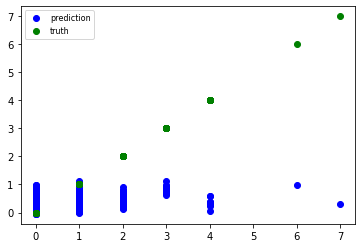

In [54]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl scoring module
scores = scoring.score_regression(
    y_test=df_all[target_column_name],
    y_pred=df_all['predicted'],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs
%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

# Model Deployment

Remember you have to deploy only one of the two models you trained.. Perform the steps in the rest of this notebook only if you wish to deploy this model.

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

**REVIEW AND EDIT**

_Operationalization_ (or Deployment) means getting the model into the cloud so that other can run it after you close the notebook. We will create a docker running on Azure Container Instances with the model.

TODO: In the cell below, send a request to the web service you deployed to test it.

In [58]:
print("Model name: {}".format(automl_model_name))
print(remote_run.model_id)

Model name: AutoML372a670941
AutoML372a670941


## Get score function

In [59]:
# Get function which will run the forecast on serialized data from the best_run
script_file_name = 'score_forecast.py'
best_run.download_file('outputs/scoring_file_v_1_0_0.py', script_file_name)

## Deploy the model as a Web Service on Azure Container Instance (ACI)

In [61]:
inference_config = InferenceConfig(environment = best_run.get_environment(), 
                                   entry_script = script_file_name)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 2, 
                                               auth_enabled=True, 
                                               enable_app_insights=True,
                                               tags = {'type': "automl-forecasting"},
                                               description = "Automl forecasting sample service")

aci_service_name = 'automl-walmart-forecast-01'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl-walmart-forecast-01
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running..............................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


TODO: In the cell below, print the logs of the web service and delete the service

In [62]:
#Gets logs from a deployed web service.
aci_service.get_logs()

'2021-01-30T10:19:41,993817605+00:00 - iot-server/run \n2021-01-30T10:19:41,994142630+00:00 - gunicorn/run \n2021-01-30T10:19:41,996448703+00:00 - rsyslog/run \n2021-01-30T10:19:42,001710500+00:00 - nginx/run \n/usr/sbin/nginx: /azureml-envs/azureml_265db83b0c6014ce472c5de2f0b97e04/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_265db83b0c6014ce472c5de2f0b97e04/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_265db83b0c6014ce472c5de2f0b97e04/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_265db83b0c6014ce472c5de2f0b97e04/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_265db83b0c6014ce472c5de2f0b97e04/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)

In [63]:
print("Deployment state: " + aci_service.state)
print("Scoring URI: " + aci_service.scoring_uri)
print("Authetication Key: " + aci_service.get_keys()[0])
print("Swagger URI: " + aci_service.swagger_uri)

Deployment state: Healthy
Scoring URI: http://2dbe921e-4114-4361-a5f6-d7a42da355fb.southcentralus.azurecontainer.io/score
Authetication Key: LlxrjA867wHP9ee4inwwOZ9yG5e7aHKy
Swagger URI: http://2dbe921e-4114-4361-a5f6-d7a42da355fb.southcentralus.azurecontainer.io/swagger.json


Maybe erase the following (endpoint)

## Call Service

In [65]:
import json
X_query = X_test.copy()

# We have to convert datetime to string, because Timestamps cannot be serialized to JSON.
X_query[time_column_name] = X_query[time_column_name].astype(str)

# The Service object accept the complex dictionary, which is internally converted to JSON string.
# The section 'data' contains the data frame in the form of dictionary.
test_sample = json.dumps({'data': X_query.to_dict(orient='records')})
response = aci_service.run(input_data = test_sample)
# translate from networkese to datascientese
try: 
    res_dict = json.loads(response)
    y_forecast_all = pd.DataFrame(res_dict['index'])
    y_forecast_all[time_column_name] = pd.to_datetime(y_forecast_all[time_column_name], unit = 'ms')
    y_forecast_all['forecast'] = res_dict['forecast']    
except:
    print(res_dict)

In [68]:
y_forecast_all

,date,item_id,store_id,forecast
0,2016-04-25,HOBBIES_2_001,TX_1,0.08
1,2016-04-25,HOBBIES_2_002,TX_1,-0.03
2,2016-04-25,HOBBIES_2_003,TX_1,0.71
3,2016-04-25,HOBBIES_2_004,TX_1,0.14
4,2016-04-25,HOBBIES_2_005,TX_1,0.11
...,...,...,...,...
835,2016-05-22,HOBBIES_2_006,TX_3,0.08
836,2016-05-22,HOBBIES_2_007,TX_3,0.29
837,2016-05-22,HOBBIES_2_008,TX_3,0.20
838,2016-05-22,HOBBIES_2_009,TX_3,0.08


# ONNX model

## Retrieve and save the best ONNX model

In [55]:
#Retrieve and save the best model

best_run, onnx_model = remote_run.get_output(return_onnx_model=True)
onnx_model_path = "results/best_model.onnx"
OnnxConverter.save_onnx_model(onnx_model, onnx_model_path)

OnnxConvertException: OnnxConvertException:
	Message: Requested an ONNX compatible model but the run has ONNX compatibility disabled.
	InnerException: None
	ErrorResponse 
{
    "error": {
        "code": "UserError",
        "message": "Requested an ONNX compatible model but the run has ONNX compatibility disabled.",
        "target": "onnx_compatible",
        "inner_error": {
            "code": "BadArgument",
            "inner_error": {
                "code": "ArgumentInvalid"
            }
        }
    }
}

## Predict with the ONNX model

In [56]:
if sys.version_info < OnnxConvertConstants.OnnxIncompatiblePythonVersion:
    python_version_compatible = True
else:
    python_version_compatible = False

def get_onnx_res(run):
    res_path = 'onnx_resource.json'
    run.download_file(name=constants.MODEL_RESOURCE_PATH_ONNX, output_file_path=res_path)
    with open(res_path) as f:
        onnx_res = json.load(f)
    return onnx_res

if python_version_compatible:
    test_df = test_data.to_pandas_dataframe()
    mdl_bytes = onnx_mdl.SerializeToString()
    onnx_res = get_onnx_res(best_run)

    onnxrt_helper = OnnxInferenceHelper(mdl_bytes, onnx_res)
    pred_onnx, pred_prob_onnx = onnxrt_helper.predict(test_df)

    print(pred_onnx)
    print(pred_prob_onnx)
else:
    print('Use Python version 3.6 or 3.7 to run the inference helper.')

NameError: name 'test_data' is not defined

# Delete Service

In [69]:
serv = Webservice(ws, 'automl-walmart-forecast-01')
serv.delete()     # don't do it accidentally